匯入套件

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

labelencoder = LabelEncoder()

plt.rcParams['font.family'] = ['Times New Roman']
English_fontcn = {'family': 'Times New Roman'}
Chinese_fontcn = {'family': 'DFKai-SB'}

讀檔

In [3]:
data = pd.read_csv('credit.csv') # 僅有20筆資料
data

,Age,Sex,Job,Housing,Risk
0,67,male,2,own,good
1,22,female,2,own,bad
2,49,male,1,own,good
3,45,male,2,free,good
4,53,male,2,free,bad
5,35,male,1,free,good
6,53,male,2,own,good
7,35,male,3,rent,good
8,61,male,1,own,good
9,28,male,3,own,bad


文字轉類別

In [4]:
for i in range(len(data.columns)):
    if (data[data.columns[i]].dtype != 'int64') | (len(data[data.columns[i]].unique()) <= 5):
        data[data.columns[i]] = labelencoder.fit_transform(data[data.columns[i]]).astype(str)

In [5]:
data

,Age,Sex,Job,Housing,Risk
0,67,1,1,1,1
1,22,0,1,1,0
2,49,1,0,1,1
3,45,1,1,0,1
4,53,1,1,0,0
5,35,1,0,0,1
6,53,1,1,1,1
7,35,1,2,2,1
8,61,1,0,1,1
9,28,1,2,1,0


切割訓練/測試集

- 10筆訓練決策樹，找出特徵規則
- 10筆測試決策樹，驗證scikit-learn/手刻套件結果

In [6]:
Train = data[:10]
Test = data[10:].reset_index(drop=True)

# scikit-learn 套件

In [7]:
target = 'Risk'  # 只有2類，good=類別1、bad=類別0
feature = data.drop([target],axis=1).columns

In [8]:
df_x = Train.drop([target],axis=1)
df_y = Train[[target]]

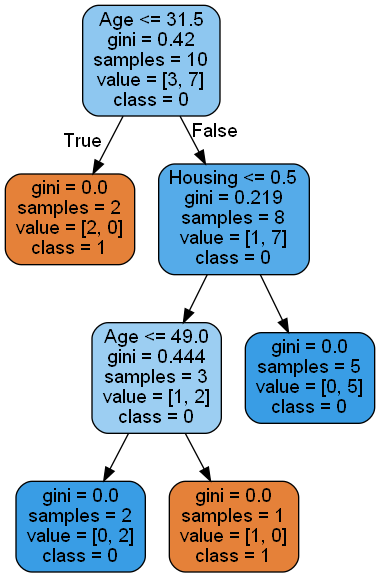

In [9]:
tree = DecisionTreeClassifier(criterion="gini", random_state=0, max_depth=20)
tree.fit(df_x, df_y)
dot_data = export_graphviz(tree, feature_names=df_x.columns, 
                        class_names=df_y[target].unique(), filled=True, rounded=True )

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

# 手刻套件

In [10]:
rule_database = {}  # 各特徵的篩選閥值
rule_list = []  # 最後被決策樹挑選出來的特徵及規則
node1_list = []  # 左邊節點(True_Node)的資訊：正負樣本數量 + Gini係數
node2_list = []  # 右邊節點(False_Node)的資訊：正負樣本數量 + Gini係數
predict_values = []  # 儲存測試結果
initial_gini = 1  # 初始Gini係數
gini_threshold = 0.1  # 若此內部節點的Gini係數小於等於0.1，就沒有必要繼續分裂下去了

自定義函式

- 節點分裂計算方式(split_node_standard())：Gini係數

In [11]:
def split_node_standard(two_node):
    node1_gini = 1
    node2_gini = 1
    node1 = list(two_node.values())[:int(len(list(two_node.values()))/2)]
    node2 = list(two_node.values())[int(len(list(two_node.values()))/2):]  
    for i in range(len(node1)):
        try:
            node1_gini = node1_gini - (node1[i]/sum(node1))**2
        except:
            node1_gini = 1
        try:
            node2_gini = node2_gini - (node2[i]/sum(node2))**2
        except:
            node2_gini = 1
    try:
        total_gigi = (sum(node1)/(sum(node1)+sum(node2)))*node1_gini + (sum(node2)/(sum(node1)+sum(node2)))*node2_gini
    except:
        total_gigi = 1
    return node1_gini, node2_gini, total_gigi

- 數值型特徵判斷規則(int_fill_node())：若此特徵 ≤ 閥值，代表符合節點規則(True)，左下節點+1，若此特徵 > 閥值，代表不符合節點規則(False)，右下節點+1

In [12]:
def int_fill_node(data, target, feature, threshold):
    Node_Num = {}
    target_values = np.sort(data[target].unique())
    for i in range(len(target_values)):
        Node_Num['True_'+target_values[i]] = 0
        Node_Num['False_'+target_values[i]] = 0
    Node_Num = dict(sorted(Node_Num.items(), reverse=True))
    if len(data[data[feature] <= threshold]) > 0:
        key = data[data[feature] <= threshold][target].value_counts()
        for i in range(len(key)):
            Node_Num['True_'+str(key.index[i])] = key.values[i]
    if len(data[data[feature] > threshold]) > 0:
        key = data[data[feature] > threshold][target].value_counts()
        for i in range(len(key)):
            Node_Num['False_'+str(key.index[i])] = key.values[i]
    return Node_Num

- 類別型特徵判斷規則(str_fill_node())：若此特徵 = 類別，代表符合節點規則(True)，左下節點+1，若此特徵 ≠ 類別，代表不符合節點規則(False)，右下節點+1

In [13]:
def str_fill_node(data, target, feature, threshold):
    Node_Num = {}
    target_values = np.sort(data[target].unique())
    for i in range(len(target_values)):
        Node_Num['True_'+target_values[i]] = 0
        Node_Num['False_'+target_values[i]] = 0
    Node_Num = dict(sorted(Node_Num.items(), reverse=True))
    if len(data[data[feature] == threshold]) > 0:
        key = data[data[feature] == threshold][target].value_counts()
        for i in range(len(key)):
            Node_Num['True_'+str(key.index[i])] = key.values[i]
    if len(data[data[feature] != threshold]) > 0:
        key = data[data[feature] != threshold][target].value_counts()
        for i in range(len(key)):
            Node_Num['False_'+str(key.index[i])] = key.values[i]
    return Node_Num

建立各特徵的篩選閥值

- 如何計算數值型特徵判斷規則：先將此欄位數值由小到大排序，計算前後兩筆資料的平均值，即為判斷規則

In [14]:
for i in range(len(feature)):
    threshold_list = []
    if Train[feature[i]].dtype == 'O':
        Obj = list(Train[feature[i]].unique())
        Obj.sort()
        rule_database[feature[i]] = Obj
    else:
        Train = Train.sort_values(by=feature[i]).reset_index(drop=True)
        int_range = Train[feature[i]].values
        for j in range(len(int_range)):
            if len(int_range) - j != 1:
                threshold_list.append(sum(int_range[j:j+2])/2)
        rule_database[feature[i]] = threshold_list
        
rule_database

{'Age': [25.0, 31.5, 35.0, 40.0, 47.0, 51.0, 53.0, 57.0, 64.0],
 'Sex': ['0', '1'],
 'Job': ['0', '1', '2'],
 'Housing': ['0', '1', '2']}

尋找規則

In [15]:
while initial_gini > gini_threshold :
    
    node1_gini_database = copy.deepcopy(rule_database)
    node2_gini_database = copy.deepcopy(rule_database)
    total_gigi_database = copy.deepcopy(rule_database)
    node_info = {}

    for i in range(len(feature)):
        for j in range(len(rule_database[feature[i]])):
            if type(rule_database[feature[i]][j]) != str:
                fill_node = int_fill_node(Train, target, feature[i], rule_database[feature[i]][j])
                node_info[feature[i]+'<='+str(rule_database[feature[i]][j])] = fill_node
            else:
                fill_node = str_fill_node(Train, target, feature[i], rule_database[feature[i]][j])
                node_info[feature[i]+'=='+rule_database[feature[i]][j]] = fill_node
            node1_gini_database[feature[i]][j],node2_gini_database[feature[i]][j],\
            total_gigi_database[feature[i]][j] = split_node_standard(fill_node)
            
    index1 = []
    for i in range(len(feature)):
        index1.append(min(total_gigi_database[feature[i]]))
        
    feature_index = index1.index(min(index1))
    gini_values = min(index1)  # 找出最小的Gini係數
    value_index = total_gigi_database[feature[feature_index]].index(min(total_gigi_database[feature[feature_index]]))
    
    key_feature = feature[feature_index]
    key_feature_rule = rule_database[feature[feature_index]][value_index]
    rule_database[key_feature].remove(key_feature_rule)
    
    if type(key_feature_rule) != str:
        rule = key_feature+'<='+str(key_feature_rule)
    else:
        rule = key_feature+'=='+key_feature_rule
    
    node1 = list(node_info[rule].values())[:int(len(list(node_info[rule]))/2)] 
    node1_list.append([*node1,node1_gini_database[key_feature][value_index]])
    node2 = list(node_info[rule].values())[int(len(list(node_info[rule]))/2):] 
    node2_list.append([*node2,node2_gini_database[key_feature][value_index]])

    if node1_gini_database[key_feature][value_index] <= gini_threshold:
        if type(key_feature_rule) != str:
            Train = Train.drop(Train[Train[key_feature] <= key_feature_rule].index,axis=0).reset_index(drop=True)
        else:
            Train = Train.drop(Train[Train[key_feature] == key_feature_rule].index,axis=0).reset_index(drop=True)
    if node2_gini_database[key_feature][value_index] <= gini_threshold:
        if type(key_feature_rule) != str:
            Train = Train.drop(Train[Train[key_feature] > key_feature_rule].index,axis=0).reset_index(drop=True)
        else:
            Train = Train.drop(Train[Train[key_feature] != key_feature_rule].index,axis=0).reset_index(drop=True)
    
    rule_list.append(rule)
    
    if gini_values < initial_gini:
        initial_gini = copy.deepcopy(gini_values)
    else:
        break

In [16]:
rule_list  # 結果和scikit-learn 套件一樣，只需要3個特徵規則就可以完成一顆決策樹

['Age<=31.5', 'Housing==0', 'Age<=47.0']

In [17]:
node1_list  # True：[[特徵規則1_good數量, 特徵規則1_bad數量, 特徵規則1_Gini係數], [特徵規則2_good數量, 特徵規則2_bad數量, 特徵規則2_Gini係數], [特徵規則3_good數量, 特徵規則3_bad數量, 特徵規則3_Gini係數]]

[[0, 2, 0.0], [2, 1, 0.4444444444444445], [2, 0, 0.0]]

In [18]:
node2_list  # False：[[特徵規則1_good數量, 特徵規則1_bad數量, 特徵規則1_Gini係數], [特徵規則2_good數量, 特徵規則2_bad數量, 特徵規則2_Gini係數], [特徵規則3_good數量, 特徵規則3_bad數量, 特徵規則3_Gini係數]]

[[7, 1, 0.21875], [5, 0, 0.0], [0, 1, 0.0]]

測試

In [19]:
for j in range(len(Test)):
    for i in range(len(rule_list)):    
        if len(rule_list[i].split('<=')) > 1:
            split_rule = rule_list[i].split('<=')
            value_type = 0
        if len(rule_list[i].split('==')) > 1:
            split_rule = rule_list[i].split('==')
            value_type = 1
        if value_type == 0:
            if Test.loc[j, split_rule[0]] <= float(split_rule[1]):
                if node1_list[i][-1] <= gini_threshold:
                    if node1_list[i][:int(len(list(node_info[rule]))/2)].index(max(node1_list[i][:int(len(list(node_info[rule]))/2)])) == 1:
                        predict_values.append('0')
                        break
                    else:
                        predict_values.append('1')
                        break
            else:
                if node2_list[i][-1] <= gini_threshold:
                    if node2_list[i][:int(len(list(node_info[rule]))/2)].index(max(node2_list[i][:int(len(list(node_info[rule]))/2)])) == 1:
                        predict_values.append('0')
                        break
                    else:
                        predict_values.append('1')
                        break
        if value_type == 1:
            if Test.loc[j, split_rule[0]] == split_rule[1]:
                if node1_list[i][-1] <= gini_threshold:
                    if node1_list[i][:int(len(list(node_info[rule]))/2)].index(max(node1_list[i][:int(len(list(node_info[rule]))/2)])) == 1:
                        predict_values.append('0')
                        break
                    else:
                        predict_values.append('1')
                        break
            else:
                if node2_list[i][-1] <= gini_threshold:
                    if node2_list[i][:int(len(list(node_info[rule]))/2)].index(max(node2_list[i][:int(len(list(node_info[rule]))/2)])) == 1:
                        predict_values.append('0')
                        break
                    else:
                        predict_values.append('1')
                        break

驗證scikit-learn和手刻套件的結果

- 透過混淆矩陣評估績效
- y_true：scikit-learn 套件測試結果
- predict_values：手刻套件測試結果

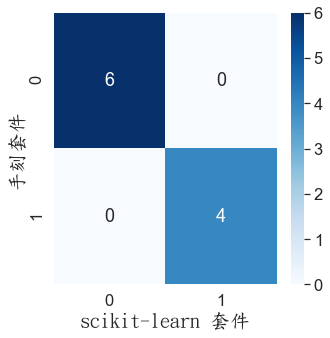

In [20]:
y_true = tree.predict(Test.drop([target],axis=1))
confusion_mtx = confusion_matrix(predict_values, y_true) 
sns.set(font_scale=1.5)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, cmap='Blues',annot=True, fmt='g')
plt.xlabel('scikit-learn 套件',fontsize=20,fontdict=Chinese_fontcn)
plt.ylabel('手刻套件',fontsize=20,fontdict=Chinese_fontcn)
plt.show() 